### Import Libraries

In [359]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

### Reading Data

In [360]:
# Read CSV files and parse date columns
users = pd.read_csv("../datasets/megaline_users.csv", parse_dates=["reg_date", "churn_date"])
calls = pd.read_csv("../datasets/megaline_calls.csv", parse_dates=["call_date"])
messages = pd.read_csv("../datasets/megaline_messages.csv", parse_dates=["message_date"])
internet = pd.read_csv("../datasets/megaline_internet.csv", parse_dates=["session_date"])
plans = pd.read_csv("../datasets/megaline_plans.csv")

In [361]:
# Keep only data from 2018
calls = calls[calls["call_date"].dt.year == 2018]
messages = messages[messages["message_date"].dt.year == 2018]
internet = internet[internet["session_date"].dt.year == 2018]

### Data preprocessing


In [362]:
#Normalize plans schema with flexible header mapping

def normalize_cols(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    out.columns = (
        out.columns
        .str.strip()
        .str.lower()
        .str.replace(" ", "_")
    )
    return out

plans = normalize_cols(plans)

# Canonical names we want -> a list of possible aliases that may appear in the CSV
ALIASES = {
    "plan_name": [
        "plan_name", "plan"
    ],
    "usd_monthly_fee": [
        "usd_monthly_fee", "usd_monthly_pay", "monthly_fee_usd", "monthly_usd_fee", "monthly_fee", "usd_monthlyfee"
    ],
    "minutes_included": [
        "minutes_included", "included_minutes", "mins_included"
    ],
    "messages_included": [
        "messages_included", "sms_included", "included_sms"
    ],
    "mb_per_month_included": [
        "mb_per_month_included", "mb_included", "included_mb", "mb_per_month_included_mb"
    ],
    "usd_per_minute": [
        "usd_per_minute", "usd_perminute", "usdperminute", "price_per_minute_usd"
    ],
    "usd_per_message": [
        "usd_per_message", "usd_permessage", "usdpermessage", "price_per_message_usd"
    ],
    "usd_per_gb": [
        "usd_per_gb", "usd_pergb", "price_per_gb_usd"
    ],
}

def pick_col(df: pd.DataFrame, aliases: list[str]) -> str | None:
    """Return the first existing column that matches the aliases list."""
    for a in aliases:
        if a in df.columns:
            return a
    return None

# Build a mapping from actual column names -> canonical names
actual_to_canonical = {}
missing_keys = []
for canonical, options in ALIASES.items():
    actual = pick_col(plans, options)
    if actual is None:
        missing_keys.append(canonical)
    else:
        actual_to_canonical[actual] = canonical

if missing_keys:
    raise ValueError(
        f"Could not find these required columns in plans: {missing_keys}\n"
        f"Available columns: {plans.columns.tolist()}"
    )

# Rename to canonical names
plans = plans.rename(columns=actual_to_canonical)

# Ensure numeric dtypes on the economics fields
for col in [
    "usd_monthly_fee", "minutes_included", "messages_included",
    "mb_per_month_included", "usd_per_minute", "usd_per_message", "usd_per_gb"
]:
    plans[col] = pd.to_numeric(plans[col], errors="coerce")

# Standardize plan_name values for clean joins
plans["plan_name"] = plans["plan_name"].astype(str).str.strip().str.lower()

In [363]:
# Build a base user-month table

# Combine all unique user-month pairs
user_month = pd.concat([
    agg_calls[["user_id", "month"]],
    agg_sms[["user_id", "month"]],
    agg_net[["user_id", "month"]]
]).drop_duplicates()

# Merge usage metrics and fill missing values with zero
user_month = (
    user_month.merge(agg_calls, on=["user_id", "month"], how="left")
              .merge(agg_sms, on=["user_id", "month"], how="left")
              .merge(agg_net, on=["user_id", "month"], how="left")
)

user_month[["minutes_month", "sms_month", "mb_month"]] = (
    user_month[["minutes_month", "sms_month", "mb_month"]].fillna(0)
)

# Add plan and city information
users_plans = users[["user_id", "city", "plan"]].merge(plans, left_on="plan", right_on="plan_name", how="left")
um = user_month.merge(users_plans, on="user_id", how="left")

In [364]:
# Create monthly aggregates for usage
calls["month"]    = calls["call_date"].dt.to_period("M")
messages["month"] = messages["message_date"].dt.to_period("M")
internet["month"] = internet["session_date"].dt.to_period("M")

# Business rule: each call rounded up to a full minute
calls["minutes_rounded"] = np.ceil(calls["duration"]).astype(int)

agg_calls = (calls.groupby(["user_id", "month"], as_index=False)["minutes_rounded"]
                  .sum()
                  .rename(columns={"minutes_rounded": "minutes_month"}))

agg_sms   = (messages.groupby(["user_id", "month"], as_index=False)["id"]
                    .count()
                    .rename(columns={"id": "sms_month"}))

agg_net   = (internet.groupby(["user_id", "month"], as_index=False)["mb_used"]
                      .sum()
                      .rename(columns={"mb_used": "mb_month"}))

In [365]:
print(agg_calls.head())
print(agg_sms.head())
print(agg_net.head())

   user_id    month  minutes_month
0     1000  2018-12            124
1     1001  2018-08            182
2     1001  2018-09            315
3     1001  2018-10            393
4     1001  2018-11            426
   user_id    month  sms_month
0     1000  2018-12         11
1     1001  2018-08         30
2     1001  2018-09         44
3     1001  2018-10         53
4     1001  2018-11         36
   user_id    month  mb_month
0     1000  2018-12   1901.47
1     1001  2018-08   6919.15
2     1001  2018-09  13314.82
3     1001  2018-10  22330.49
4     1001  2018-11  18504.30


In [366]:
# Build the base user-month table
user_month = pd.concat(
    [agg_calls[["user_id", "month"]],
     agg_sms[["user_id", "month"]],
     agg_net[["user_id", "month"]]],
    ignore_index=True
).drop_duplicates()

um = (user_month
      .merge(agg_calls, on=["user_id", "month"], how="left")
      .merge(agg_sms,   on=["user_id", "month"], how="left")
      .merge(agg_net,   on=["user_id", "month"], how="left"))

um[["minutes_month", "sms_month", "mb_month"]] = um[["minutes_month", "sms_month", "mb_month"]].fillna(0)

In [367]:
user_month.head()

,user_id,month
0,1000,2018-12
1,1001,2018-08
2,1001,2018-09
3,1001,2018-10
4,1001,2018-11


In [368]:
# Merge user info and plan economics without suffixes

# Users: keep only what we need and normalize plan labels
users_slim = users[["user_id", "city", "plan"]].copy()
users_slim["plan"] = users_slim["plan"].astype(str).str.strip().str.lower()

# Plans: select canonical columns only and align key name
plans_slim = plans[[
    "plan_name", "usd_monthly_fee", "minutes_included", "messages_included",
    "mb_per_month_included", "usd_per_minute", "usd_per_message", "usd_per_gb"
]].copy()
plans_slim = plans_slim.rename(columns={"plan_name": "plan"})

# Users + plans
users_plans = users_slim.merge(plans_slim, on="plan", how="left")

# Attach to user-month table
um = um.merge(users_plans, on="user_id", how="left")

In [369]:
um.head()

,user_id,month,minutes_month,sms_month,mb_month,city,plan,usd_monthly_fee,minutes_included,messages_included,mb_per_month_included,usd_per_minute,usd_per_message,usd_per_gb
0,1000,2018-12,124.0,11.0,1901.47,"Atlanta-Sandy Springs-Roswell, GA MSA",ultimate,70,3000,1000,30720,0.01,0.01,7
1,1001,2018-08,182.0,30.0,6919.15,"Seattle-Tacoma-Bellevue, WA MSA",surf,20,500,50,15360,0.03,0.03,10
2,1001,2018-09,315.0,44.0,13314.82,"Seattle-Tacoma-Bellevue, WA MSA",surf,20,500,50,15360,0.03,0.03,10
3,1001,2018-10,393.0,53.0,22330.49,"Seattle-Tacoma-Bellevue, WA MSA",surf,20,500,50,15360,0.03,0.03,10
4,1001,2018-11,426.0,36.0,18504.30,"Seattle-Tacoma-Bellevue, WA MSA",surf,20,500,50,15360,0.03,0.03,10


In [370]:
# Validate that all required plan columns are present in `um`
required_cols = [
    "minutes_included", "messages_included", "mb_per_month_included",
    "usd_per_minute", "usd_per_message", "usd_per_gb", "usd_monthly_fee"
]
missing_um = [c for c in required_cols if c not in um.columns]
if missing_um:
    print("Columns in um:", um.columns.tolist())
    raise AssertionError(f"Missing plan columns in um: {missing_um}")

In [371]:
# Revenue calculation
def compute_revenue(row):
    inc_min = row["minutes_included"]
    inc_sms = row["messages_included"]
    inc_mb  = row["mb_per_month_included"]

    used_min = row["minutes_month"]
    used_sms = row["sms_month"]
    used_mb  = row["mb_month"]

    # Overages (non-negative)
    over_min = max(0, used_min - inc_min)
    over_sms = max(0, used_sms - inc_sms)
    over_mb  = max(0, used_mb - inc_mb)

    # Monthly data overage is billed per full GB (rounded up)
    over_gb = int(np.ceil(over_mb / 1024)) if over_mb > 0 else 0

    cost_min = over_min * row["usd_per_minute"]
    cost_sms = over_sms * row["usd_per_message"]
    cost_gb  = over_gb  * row["usd_per_gb"]

    return row["usd_monthly_fee"] + cost_min + cost_sms + cost_gb

um["monthly_revenue"] = um.apply(compute_revenue, axis=1)

In [372]:
# Quick checks
print("Monthly revenue nulls:", um["monthly_revenue"].isna().sum())
print(
    um.groupby("plan")["monthly_revenue"]
      .describe()
      .round(2)
)
um.head()

Monthly revenue nulls: 0
           count   mean    std   min   25%    50%    75%     max
plan                                                            
surf      1573.0  60.71  55.39  20.0  20.0  40.36  80.36  590.37
ultimate   720.0  72.31  11.40  70.0  70.0  70.00  70.00  182.00


,user_id,month,minutes_month,sms_month,mb_month,city,plan,usd_monthly_fee,minutes_included,messages_included,mb_per_month_included,usd_per_minute,usd_per_message,usd_per_gb,monthly_revenue
0,1000,2018-12,124.0,11.0,1901.47,"Atlanta-Sandy Springs-Roswell, GA MSA",ultimate,70,3000,1000,30720,0.01,0.01,7,70.00
1,1001,2018-08,182.0,30.0,6919.15,"Seattle-Tacoma-Bellevue, WA MSA",surf,20,500,50,15360,0.03,0.03,10,20.00
2,1001,2018-09,315.0,44.0,13314.82,"Seattle-Tacoma-Bellevue, WA MSA",surf,20,500,50,15360,0.03,0.03,10,20.00
3,1001,2018-10,393.0,53.0,22330.49,"Seattle-Tacoma-Bellevue, WA MSA",surf,20,500,50,15360,0.03,0.03,10,90.09
4,1001,2018-11,426.0,36.0,18504.30,"Seattle-Tacoma-Bellevue, WA MSA",surf,20,500,50,15360,0.03,0.03,10,60.00


In [373]:
# Set a consistent style
plt.style.use("seaborn-v0_8-whitegrid")

# Make plots a bit bigger
plt.rcParams["figure.figsize"] = (10, 5)

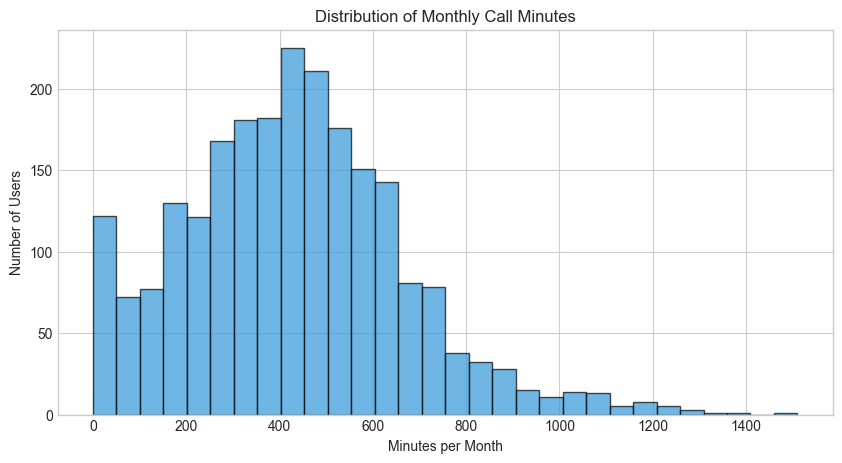

In [374]:
# Histogram — Minutes per Month
plt.hist(um["minutes_month"], bins=30, color="#3498db", edgecolor="black", alpha=0.7)
plt.title("Distribution of Monthly Call Minutes")
plt.xlabel("Minutes per Month")
plt.ylabel("Number of Users")
plt.show()

Most customers use fewer than 600–800 minutes per month.
There’s a right-skew (a long tail), meaning a few users make very high call usage.

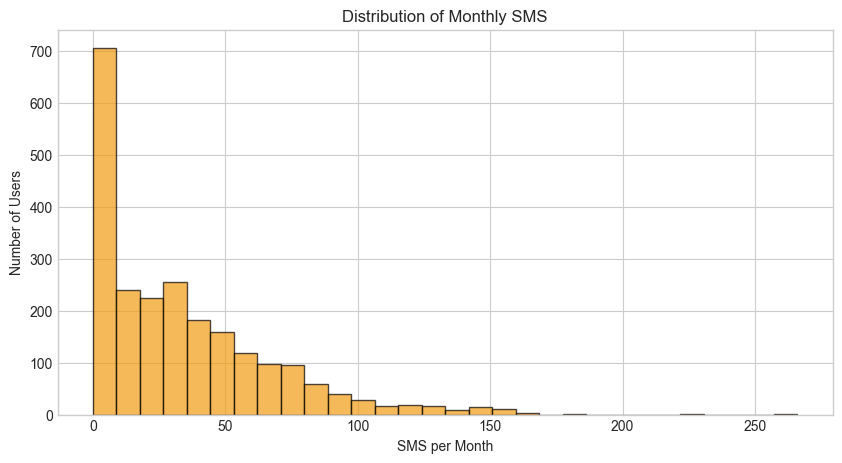

In [375]:
# Histogram — SMS per Month
plt.hist(um["sms_month"], bins=30, color="#f39c12", edgecolor="black", alpha=0.7)
plt.title("Distribution of Monthly SMS")
plt.xlabel("SMS per Month")
plt.ylabel("Number of Users")
plt.show()

The SMS distribution is highly right-skewed — most people send few or no messages,
while a small number of users send a lot (hundreds).

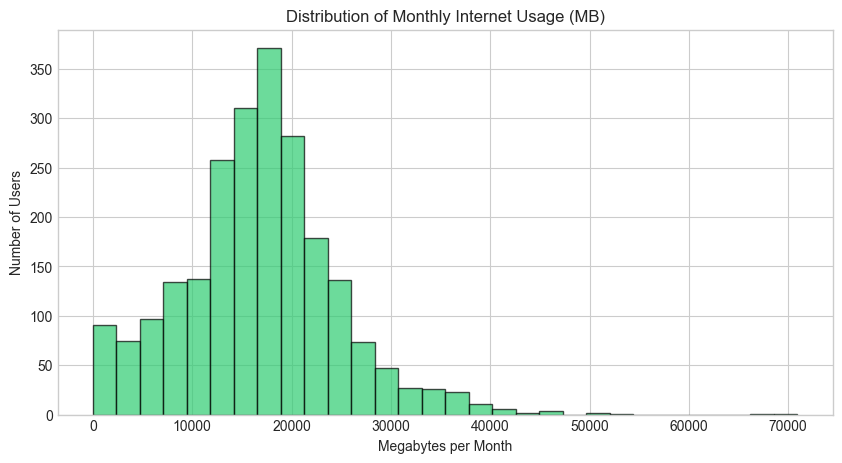

In [376]:
# Histogram — Data Usage (MB)
plt.hist(um["mb_month"], bins=30, color="#2ecc71", edgecolor="black", alpha=0.7)
plt.title("Distribution of Monthly Internet Usage (MB)")
plt.xlabel("Megabytes per Month")
plt.ylabel("Number of Users")
plt.show()

Many users stay under ~15,000 MB (≈15 GB), but some go far beyond the limit —
consistent with typical mobile data behavior.

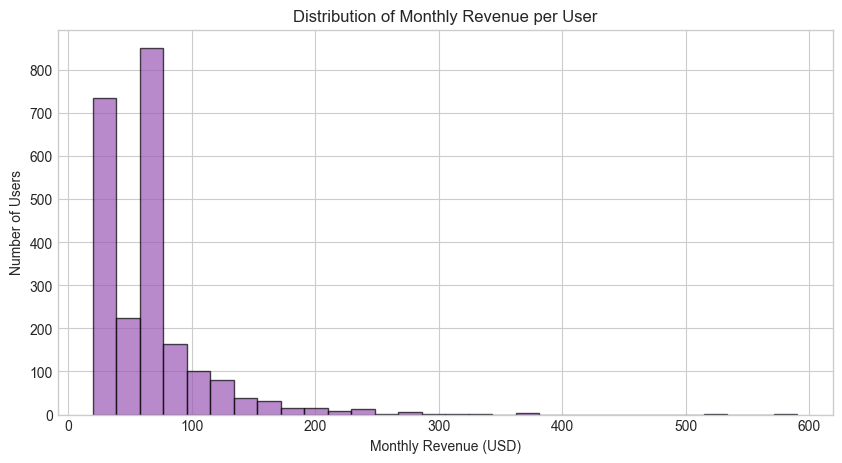

In [377]:
plt.hist(um["monthly_revenue"], bins=30, color="#9b59b6", edgecolor="black", alpha=0.7)
plt.title("Distribution of Monthly Revenue per User")
plt.xlabel("Monthly Revenue (USD)")
plt.ylabel("Number of Users")
plt.show()

Revenue clusters around the plan base prices ($20 and $70), with occasional higher values
from overages — this indicates that most users don’t exceed their limits,
but some contribute additional revenue from extra minutes, data, or SMS.

--- 

### Hypothesis Testing

We’ll test two hypotheses using statistical methods to determine whether observed differences in revenue are statistically significant or just random variation.


#### Hypothesis 1:

The average monthly revenue differs between the Surf and Ultimate plans.

Formulation:
- H₀ (null hypothesis): The average monthly revenue for Surf and Ultimate users is equal.
- H₁ (alternative hypothesis): The average monthly revenue for Surf and Ultimate users is different.

In [378]:
# Separate revenue by plan
surf_rev = um.loc[um["plan"] == "surf", "monthly_revenue"]
ultimate_rev = um.loc[um["plan"] == "ultimate", "monthly_revenue"]

# (Optional) Normality test – Shapiro-Wilk on a sample for speed
print(stats.shapiro(surf_rev.sample(500, random_state=42)))
print(stats.shapiro(ultimate_rev.sample(500, random_state=42)))

# Check equality of variances (Levene's test)
levene_test = stats.levene(surf_rev, ultimate_rev)
print("Levene test p-value:", levene_test.pvalue)

ShapiroResult(statistic=np.float64(0.7241777754675051), pvalue=np.float64(6.426681244543416e-28))
ShapiroResult(statistic=np.float64(0.23573817659038876), pvalue=np.float64(6.776521494033118e-41))
Levene test p-value: 5.028876110654919e-83


In [379]:
# Two-sample t-test (Welch’s version, does not assume equal variances)
t_stat, p_value = stats.ttest_ind(surf_rev, ultimate_rev, equal_var=False)

print(f"T-statistic = {t_stat:.3f}")
print(f"P-value = {p_value:.4f}")

T-statistic = -7.952
P-value = 0.0000


Interpretation
- If p-value < 0.05, reject H₀ → there is a significant difference in average revenue between the two plans.
- If p-value ≥ 0.05, fail to reject H₀ → there’s no statistical evidence of a difference.

Therefore

We reject null hypothesis, there is a statistically significant difference in the average monthly revenue between the two plans.


- The result indicates that the difference in mean revenue between Surf and Ultimate users is not due to random chance.
- Users on the Ultimate plan generate significantly higher monthly revenue.
- This supports the business intuition that the Ultimate plan is more profitable, even if it’s used by fewer customers.

In [380]:
# Summary statistics by plan
um.groupby("plan")["monthly_revenue"].agg(["mean", "std"]).round(2)

,mean,std
plan,,
surf,60.71,55.39
ultimate,72.31,11.40


1.	Average revenue:
- On average, Ultimate users generate about $72.31 per month, while Surf users generate about $60.71.
- That’s a ~$11.6 difference in favor of the Ultimate plan.

2.	Revenue variability:
- The Surf plan shows a much higher standard deviation (55.39), meaning there’s greater variability among Surf users — some pay the base $20, while others exceed usage and pay much more.
- The Ultimate plan’s lower standard deviation (11.40) indicates more consistent spending; users tend to stay near the base $70 fee.

3.	Business insight:
- Although the Ultimate plan produces higher average revenue, the Surf plan generates more variability — possibly more upsell potential from heavy users.
- The company could focus on encouraging high-usage Surf customers to upgrade to Ultimate, stabilizing revenue and reducing volatility.

/var/folders/9g/y9hgn7sd4_g82q2m37vjhtlw0000gn/T/ipykernel_4724/1030351834.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=um, x="plan", y="monthly_revenue", palette="pastel")


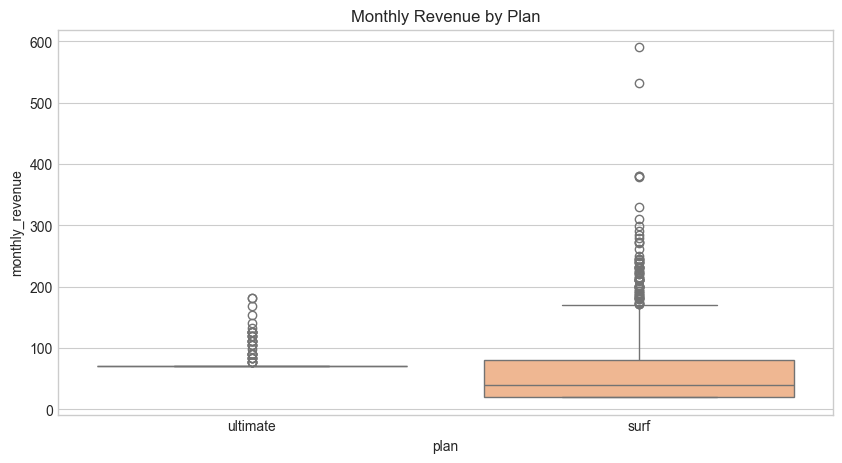

In [381]:
# Visual comparison (boxplot)
sns.boxplot(data=um, x="plan", y="monthly_revenue", palette="pastel")
plt.title("Monthly Revenue by Plan")
plt.show()

---

#### Hypothesis 2:

The average monthly revenue for users in the New York–New Jersey area differs from that of users in other regions.

Formulation
- H₀: The average monthly revenue in the NY–NJ area is equal to that of other regions.
- H₁: The average monthly revenue in the NY–NJ area is different from other regions.

In [382]:
# Split users by location
ny_nj_rev = um.loc[um["city"].str.contains("New York|New Jersey"), "monthly_revenue"]
other_rev = um.loc[~um["city"].str.contains("New York|New Jersey"), "monthly_revenue"]

# Check variances
print(stats.levene(ny_nj_rev, other_rev))

LeveneResult(statistic=np.float64(2.345281651730069), pvalue=np.float64(0.125800911096124))


In [383]:
# Independent two-sample t-test
t_stat2, p_value2 = stats.ttest_ind(ny_nj_rev, other_rev, equal_var=False)

print(f"T-statistic = {t_stat2:.3f}")
print(f"P-value = {p_value2:.4f}")

T-statistic = -2.131
P-value = 0.0335


Interpretation
- If p-value < 0.05, reject H₀ → revenue differs significantly between NY–NJ and other regions.
- If p-value ≥ 0.05, fail to reject H₀ → there’s no significant difference in revenue by region.

Therefore

We reject the null hypothesis, there is a statistically significant difference in average monthly revenue between users in the New York–New Jersey area and those in other regions.

- The result indicates that location has a measurable impact on user revenue.
- Although statistically significant, the magnitude of this difference (effect size) should be examined to confirm whether it’s also business-significant.

In [384]:
# Create the region label column first
um["region_label"] = np.where(
    um["city"].str.contains("New York|New Jersey", case=False, na=False),
    "NY–NJ Area",
    "Other Regions")

um.groupby("region_label")["monthly_revenue"].mean().round(2)

region_label
NY–NJ Area       59.92
Other Regions    65.22
Name: monthly_revenue, dtype: float64

- The difference is statistically significant but negative, meaning users in the New York–New Jersey area spend less on average than users elsewhere.
- The difference is about $5 per month, which is small but measurable.
- So while location does have an effect, it’s not economically large, the impact is statistically real but not major in business terms.

/var/folders/9g/y9hgn7sd4_g82q2m37vjhtlw0000gn/T/ipykernel_4724/2949867173.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


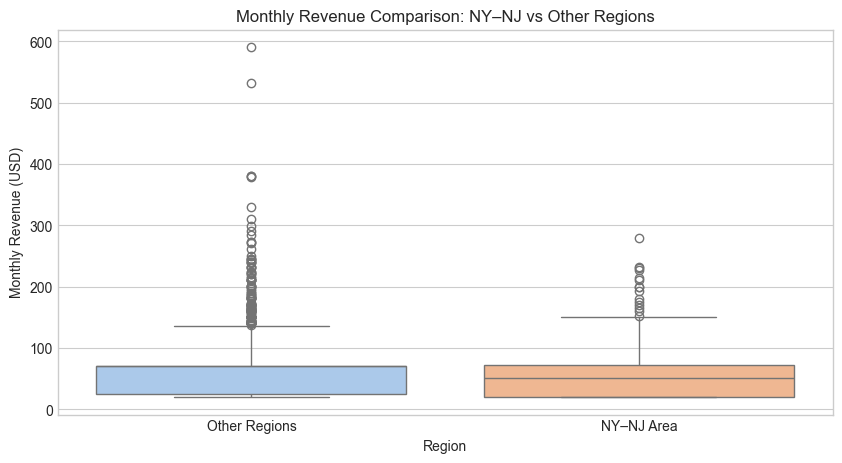

In [385]:
# Now plot using that new column
sns.boxplot(
    data=um,
    x="region_label",        
    y="monthly_revenue",
    palette="pastel"
)
plt.xlabel("Region")
plt.ylabel("Monthly Revenue (USD)")
plt.title("Monthly Revenue Comparison: NY–NJ vs Other Regions")
plt.show()